In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pathlib import Path
from osgeo import gdal
import numpy as np
import rasterio
import cv2

In [2]:
image = gdal.Open(r"C:\Users\nicom\Desktop\MAESTRIA\Maestria_semestre_2\Remote_sensing\datos nicolas\HYPERION\EO1H0150332013171110KF_REF.dat")
bands, xSize, ySize = image.RasterCount, image.RasterXSize, image.RasterYSize
print(f"Image loaded: # Ráster {bands}, {xSize}, {ySize}")

Image loaded: # Ráster 242, 256, 3177


In [3]:
complete_img = np.dstack([image.GetRasterBand(band).ReadAsArray() for band in range(1,bands+1)])

In [4]:
complete_img.shape

(3177, 256, 242)

In [5]:
def normalize(raster):
    n=30000
    raster[raster>n]=n
    min_raster, max_raster, new_max, new_min = raster.min(), raster.max(), 255, 0
    return ((raster-min_raster)*((new_max-new_min)/(max_raster-min_raster))+new_min).astype(int)

In [6]:
rgb = np.dstack((
    normalize(complete_img[:,:,30]), #39
    normalize(complete_img[:,:,21]), #30
    normalize(complete_img[:,:,10])  #12
)) #RGB = B4B3B2

In [7]:
cir = np.dstack((
    normalize(complete_img[:,:,43]), 
    normalize(complete_img[:,:,30]),
    normalize(complete_img[:,:,21])
)) #RGB = B4B3B2

In [8]:
dif_rgb = np.dstack((
    normalize(complete_img[:,:,190]), 
    normalize(complete_img[:,:,100]),
    normalize(complete_img[:,:,90])
)) #RGB = B4B3B2

<Figure size 360x2160 with 0 Axes>

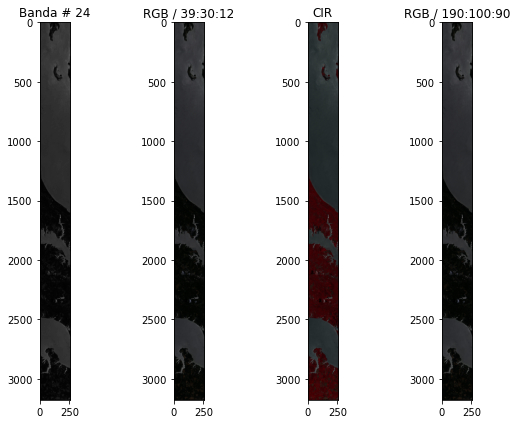

In [9]:
plt.figure(figsize=(5, 30))
fig, axes = plt.subplots(1, 4, figsize=(8, 6))
ax = axes.ravel()

ax[0].imshow(complete_img[:,:,24], cmap=plt.cm.gray)
ax[0].set_title("Banda # 24")
ax[1].imshow(rgb)
ax[1].set_title("RGB / 39:30:12")
ax[2].imshow(cir)
ax[2].set_title("CIR")
ax[3].imshow(rgb)
ax[3].set_title("RGB / 190:100:90")

fig.tight_layout()
plt.show()

import spectral.io.envi as envi
img = envi.open(r"C:\Users\nicom\Desktop\MAESTRIA\Maestria_semestre_2\Remote_sensing\datos nicolas\HYPERION\EO1H0150332013171110KF_REF.hdr", r"C:\Users\nicom\Desktop\MAESTRIA\Maestria_semestre_2\Remote_sensing\datos nicolas\HYPERION\EO1H0150332013171110KF_REF.dat")
prin(img)
from spectral import *

view = imshow(img, (40, 31, 13))
print(view)

In [10]:
def kernel(size=3, value=1):
    """Kernel usado para el filtro en convolución"""
    return value * np.ones((size, size))

def mse(image_one, image_two):
    """Mean Squared Error"""
    return np.sum(np.square(np.subtract(image_one, image_two))) / (image_one.shape[0] * image_two.shape[1])

In [19]:
img = complete_img[:,:,130]

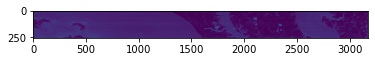

In [20]:
plt.imshow(img.transpose())

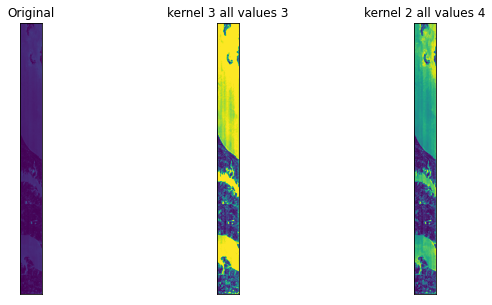

In [21]:
image_filtered_1 = cv2.filter2D(img, -1, kernel(3,3))
image_filtered_2 = cv2.filter2D(img, -1, kernel(2,4))

plt.figure(figsize=(10, 5))
plt.subplot(131),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(image_filtered_1),plt.title('kernel 3 all values 3')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(image_filtered_2),plt.title('kernel 2 all values 4')
plt.xticks([]), plt.yticks([])
plt.show()

In [22]:
print(f"MSE entre la imagen orginal y la filtrada con una matriz 2x2 llena de 4's = {mse(img,image_filtered_2)}")

MSE entre la imagen orginal y la filtrada con una matriz 2x2 llena de 4's = 444.7169020007082


In [23]:
print(f"MSE entre la imagen orginal y la filtrada con una matriz 3x3 llena de 3's = {mse(img,image_filtered_1)}")

MSE entre la imagen orginal y la filtrada con una matriz 3x3 llena de 3's = 1346.1323624881963


In [24]:
pca = PCA(n_components = 10)
# Recortamos la imagen
w, h, c = complete_img.shape
# Organizamos en un arreglo de 2 D
data_transformed =  complete_img.reshape((w * h, c))
principalComponents = pca.fit_transform(data_transformed)
final_cube = principalComponents.reshape((w, h, pca.n_components))

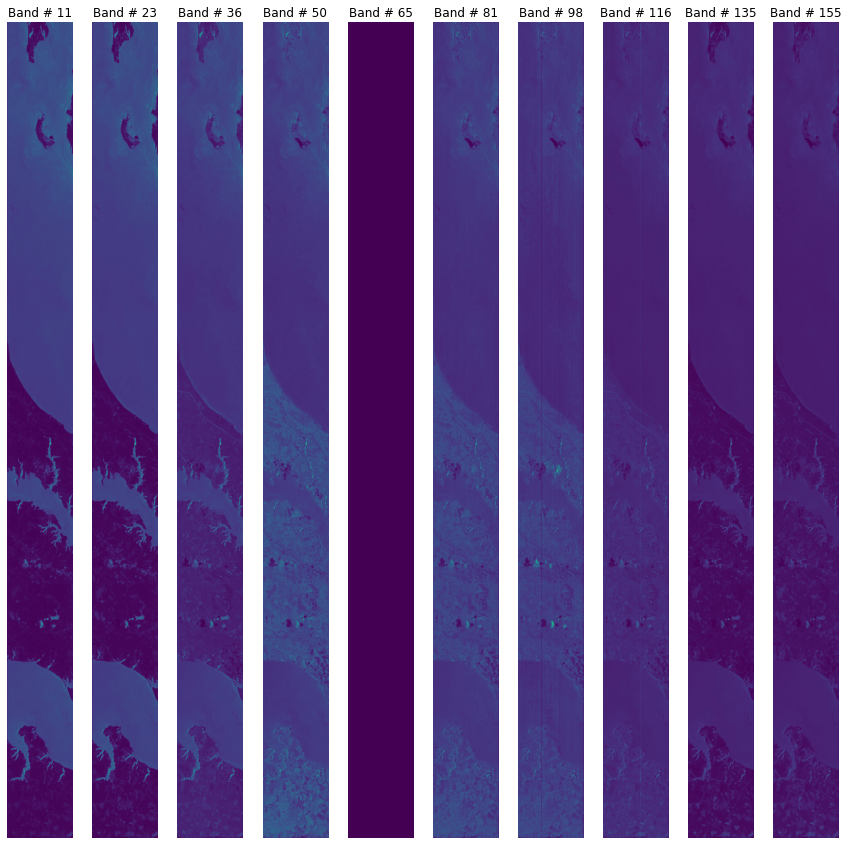

In [25]:
# Graficamos las 3 bandas
fig = plt.figure(figsize=(15, 15))
n=10
ban = 0
for i in range(1, 1+n):
    fig.add_subplot(1,n, i)
    ban += i+10
    plt.imshow(complete_img[:,:,ban])
    plt.axis('off')
    plt.title(f'Band # {ban}')

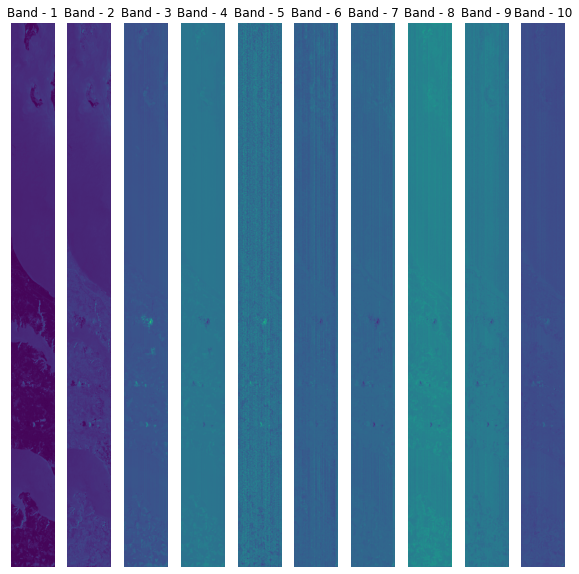

In [26]:
# Graficamos las 3 bandas
fig = plt.figure(figsize=(10, 10))
n = pca.n_components
for i in range(1, 1+n):
    fig.add_subplot(1,n, i)
    plt.imshow(final_cube[:,:,i-1])
    plt.axis('off')
    plt.title(f'Band - {i}')

In [27]:
RED = complete_img[:,:,39].astype('float32')
NIR = complete_img[:,:,49].astype('float32')

In [28]:
NDVI = np.where(
           np.add(NIR, RED) == 0,
           0,
           np.divide(np.subtract(NIR, RED), np.add(NIR, RED))
             )

MSR = np.where(
           np.add(NIR, RED) + 1 <= 0,
           0,
           np.divide(np.subtract(NIR, RED) - 1 , np.sqrt(np.add(NIR, RED) + 1))
             )

TVI = np.where(
           np.add(NDVI, 0.5) <= 0,
           0,
           np.sqrt(np.add(NDVI, 0.5))
             )

<ipython-input-28-5fdf2b2680bc>:4: RuntimeWarning: invalid value encountered in true_divide
  np.divide(np.subtract(NIR, RED), np.add(NIR, RED))
<ipython-input-28-5fdf2b2680bc>:16: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(np.add(NDVI, 0.5))


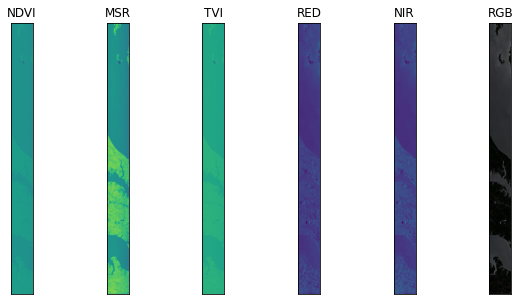

In [32]:
plt.figure(figsize=(10, 5))
plt.subplot(161),plt.imshow(NDVI),plt.title('NDVI')
plt.xticks([]), plt.yticks([])
plt.subplot(162),plt.imshow(MSR),plt.title('MSR')
plt.xticks([]), plt.yticks([])
plt.subplot(163),plt.imshow(TVI),plt.title('TVI')
plt.xticks([]), plt.yticks([])
plt.subplot(164),plt.imshow(RED),plt.title('RED')
plt.xticks([]), plt.yticks([])
plt.subplot(165),plt.imshow(NIR),plt.title('NIR')
plt.xticks([]), plt.yticks([])
plt.subplot(166),plt.imshow(rgb),plt.title('RGB')
plt.xticks([]), plt.yticks([])
plt.show()

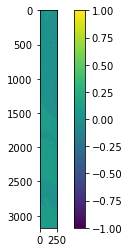

In [30]:
a = plt.imshow(NDVI)
plt.colorbar(a)